In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# basic imports
import cv2
import random
import time
import pickle
import scanpy as sc
from glob import glob
from scipy.io import mmread
from orderedset import OrderedSet
from sklearn.linear_model import LinearRegression
import pandas as pd
from copy import deepcopy
from bs4 import BeautifulSoup
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr, zscore, rankdata, fisher_exact, ttest_ind, linregress
import os, sys
from multiprocessing import Pool
import statsmodels.api as sm
from matplotlib_venn import venn2, venn3
import scipy
from matplotlib.patches import PathPatch
from copy import deepcopy
import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [3]:
pseudo_df = pd.read_csv('./Data/dim30_F1200_R07.pseudo', 
                        index_col=0)

In [4]:
read_df = pd.read_csv('./Data/peak_order.csv', index_col=0)

In [5]:
allopen_read_df = read_df.loc[read_df.sum(axis=1)==read_df.shape[1]]
sc_bookmarked_peaks = allopen_read_df.index.tolist()
unbookmarked_peaks = list(set(read_df.index)-set(sc_bookmarked_peaks))

In [6]:
peak_bed_df = pd.read_csv('./Data/merge.bed', sep='\t', header=None)

In [7]:
sc_bookmarked_peak_bed_df = peak_bed_df[peak_bed_df[3].isin(sc_bookmarked_peaks)]
unbookmarked_peak_bed_df = peak_bed_df[~peak_bed_df[3].isin(sc_bookmarked_peaks)]

In [8]:
def cal_tfidf(data): 
    data=scipy.sparse.csr_matrix(data.T)

    peaks=data.sum()
    tf=(data/peaks)

    idf=data.shape[1]/data.sum(axis=1)

    tfidf=np.dot(scipy.sparse.diags(np.squeeze(np.asarray(idf))),tf)
    
    tfidf=pd.DataFrame(tfidf.todense())
    
    
    return tfidf

In [9]:
t=cal_tfidf(read_df).T
order=t.apply(lambda x: x.argmax(),axis=1)
order.index=read_df.index
order.columns=read_df.columns

In [10]:
sigma = 1.5
kernel_size = (5, 5)

clus_binary_df = read_df.loc[order.sort_values().index]
gsb_read_df = pd.DataFrame(cv2.GaussianBlur(clus_binary_df.values, kernel_size, sigma), 
                           index=clus_binary_df.index, columns=clus_binary_df.columns)

In [12]:
color_df = pd.DataFrame({'c':['black']*len(sc_bookmarked_peaks)+['white']*len(unbookmarked_peaks)}, 
                        index=sc_bookmarked_peaks+unbookmarked_peaks)

# Fig 2A

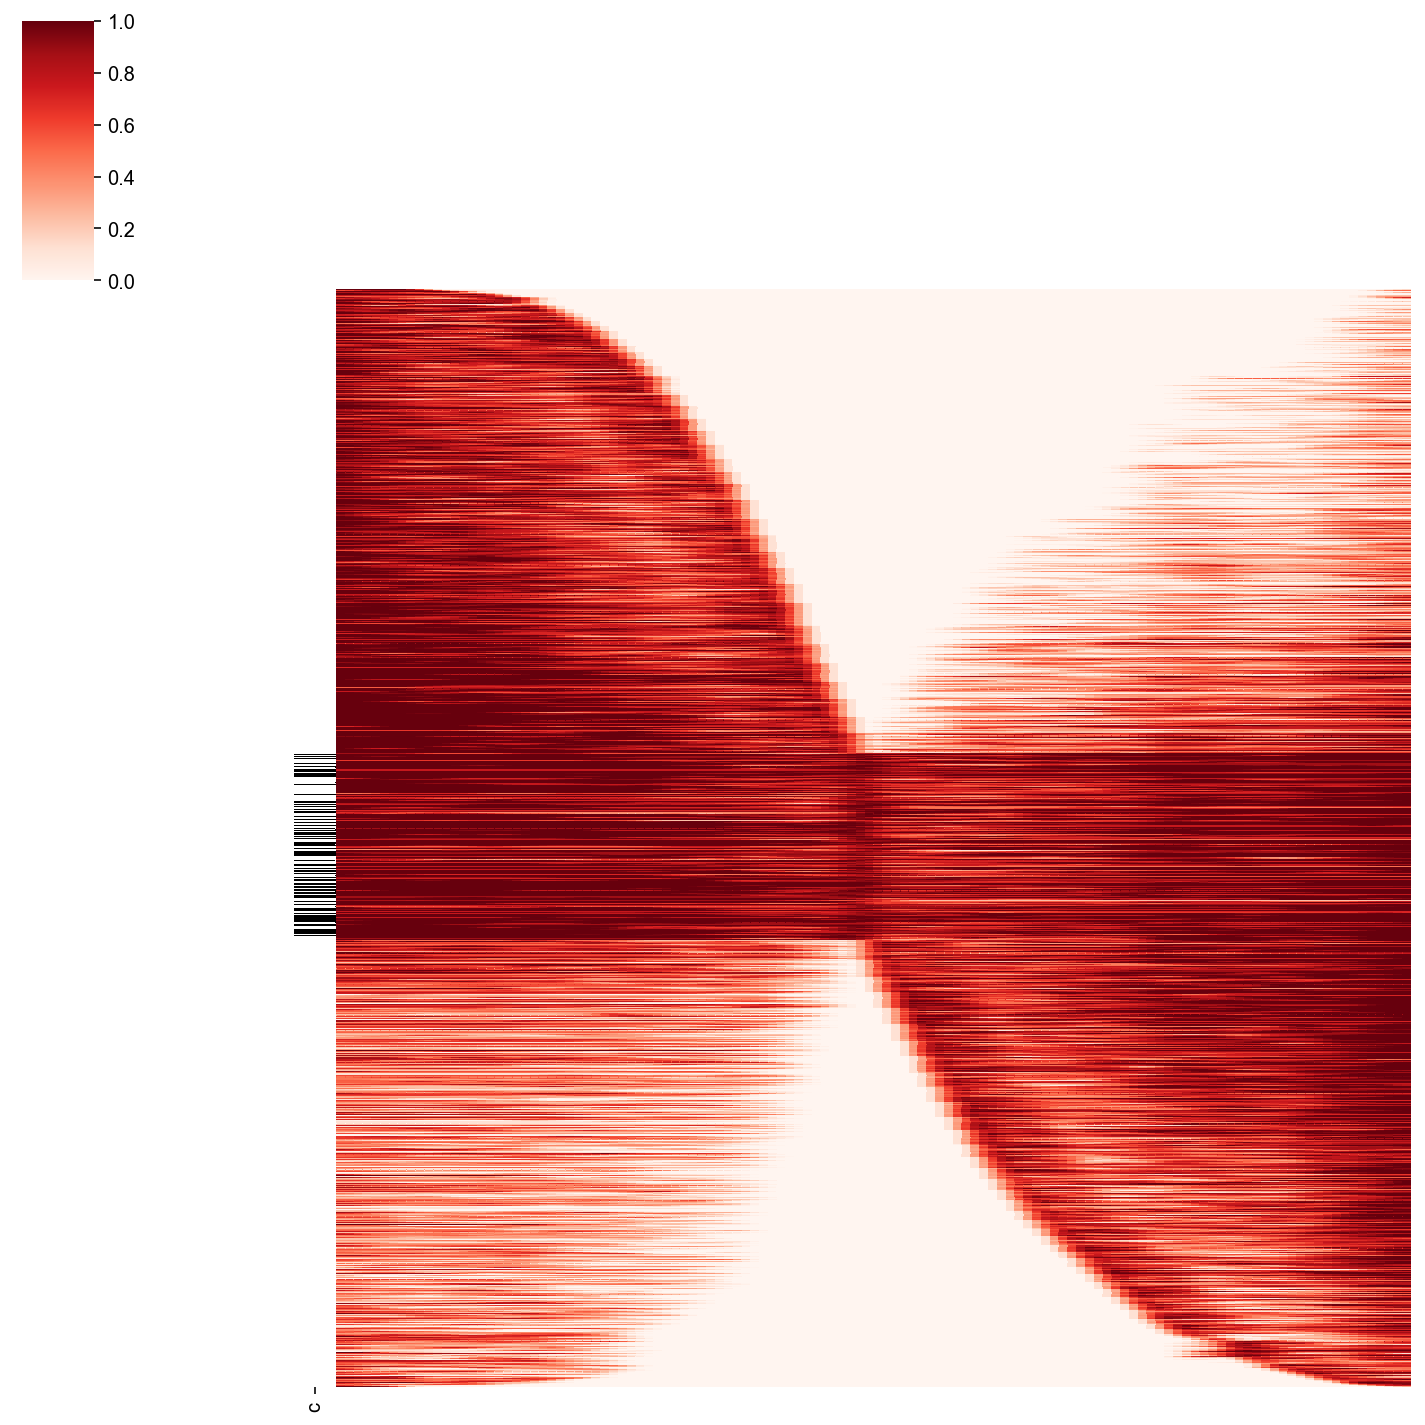

In [13]:
sns.clustermap(gsb_read_df, row_cluster=False, col_cluster=False, cmap='Reds', 
               xticklabels=False, yticklabels=False, row_colors=color_df['c'])

# Fig 2B

In [14]:
nb_sc_bookmark = len(sc_bookmarked_peaks)
nb_unbookmark = len(unbookmarked_peaks)

([<matplotlib.patches.Wedge at 0x2b5c0ebbe6d0>,
 [Text(0.27399631279443154, 1.16830048385467, 'sc_bookmarked'),
  Text(-0.2511633117954379, -1.070942104321213, 'unbookmarked')],
 [Text(0.15983118246341838, 0.6815086155818908, '7.33%'),
  Text(-0.13699817007023882, -0.5841502387206615, '92.67%')])

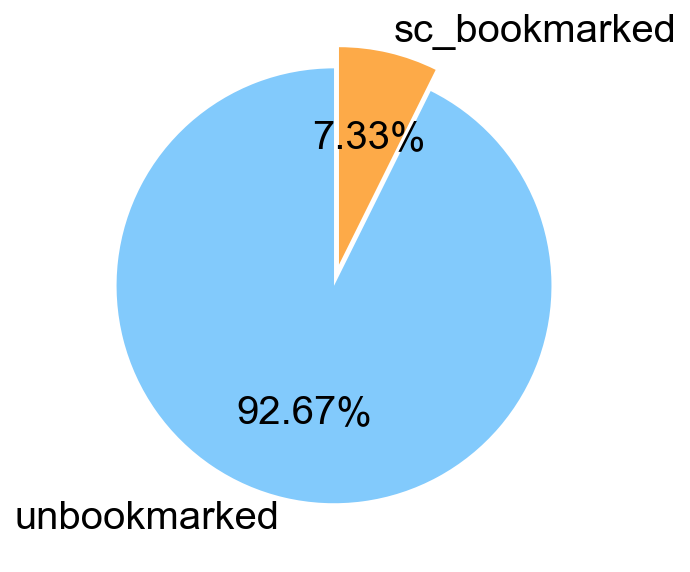

In [15]:
fig = plt.figure(figsize=(5,5))
ax21 = plt.subplot(111)
ax21.pie([nb_sc_bookmark,nb_unbookmark], labels=['sc_bookmarked','unbookmarked'], explode=[0.1,0], autopct='%1.2f%%', 
         startangle=90, textprops={'fontsize': 20}, counterclock=False, colors=['#fdaa48','#82cafc'])

# Fig S2F

In [19]:
sc_bookmarked_peak_file = './Data/sc_bookmarked.peaks.bed'
unbookmarked_peak_file = './Data/unbookmarked.peaks.bed'

In [31]:
bulk_bookmark_peak_file = './Data/lo2_bookmark.peaks.bed'
bulk_shared_peak_file = './Data/hepG2_huh7_lo2_overlapbookmark.peaks.bed'
bulk_unique_peak_file = './Data/lo2_uniqbookmark.peaks.bed'

In [21]:
nb_bulk_bookmark = int(os.popen('wc -l %s' % bulk_bookmark_peak_file).read().strip().split(' ')[0])

In [22]:
nb_sc_bookmark_overlap_bulk = int(os.popen('bedtools intersect -a %s -b %s -wa | sort -u | wc -l' % (sc_bookmarked_peak_file, bulk_bookmark_peak_file)).read().strip().split(' ')[0])
nb_unbookmark_overlap_bulk = int(os.popen('bedtools intersect -a %s -b %s -wa | sort -u | wc -l' % (unbookmarked_peak_file, bulk_bookmark_peak_file)).read().strip().split(' ')[0])

([<matplotlib.patches.Wedge at 0x2b5c0f80c790>,
 [Text(0.547251491271928, -1.0679493458496292, 'bulk_detected'),
  Text(-0.5016471545044766, 0.9789535905126259, '')],
 [Text(0.3192300365752913, -0.622970451745617, '84.93%'),
  Text(-0.2736257206388054, 0.5339746857341595, '15.07%')])

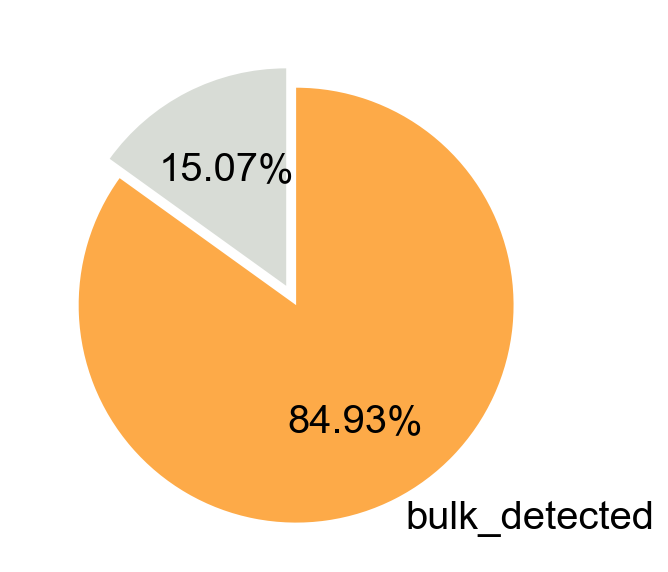

In [23]:
fig = plt.figure(figsize=(5,5))
ax21 = plt.subplot(111)
ax21.pie([nb_sc_bookmark_overlap_bulk,nb_sc_bookmark-nb_sc_bookmark_overlap_bulk], colors=['#fdaa48','#d8dcd6'], explode=[0.1,0],
         labels=['bulk_detected',''], autopct='%1.2f%%', startangle=90, textprops={'fontsize': 20}, counterclock=False)

([<matplotlib.patches.Wedge at 0x2b5c0f87cb90>,
 [Text(0.17160523041432413, 1.1876664703924442, 'sc_bookmarked'),
  Text(-0.15730480728782792, -1.088694262685415, '')],
 [Text(0.10010305107502239, 0.6928054410622592, '4.57%'),
  Text(-0.08580262215699704, -0.5938332341920445, '95.43%')])

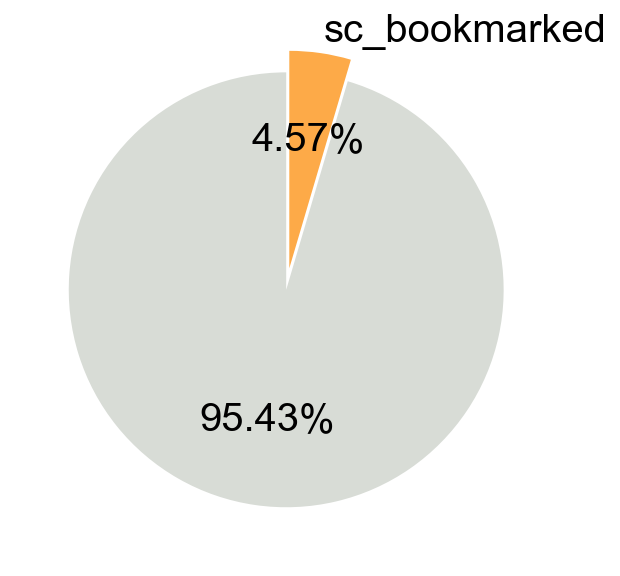

In [24]:
fig = plt.figure(figsize=(5,5))
ax21 = plt.subplot(111)
ax21.pie([nb_sc_bookmark_overlap_bulk,nb_bulk_bookmark-nb_sc_bookmark_overlap_bulk], explode=[0.1,0],
         labels=['sc_bookmarked',''], autopct='%1.2f%%', startangle=90, textprops={'fontsize': 20}, counterclock=False, colors=['#fdaa48','#d8dcd6'])  

# Fig S2I

In [26]:
nb_sc_bookmark_overlap_shared = int(os.popen('bedtools intersect -a %s -b %s -wa | sort -u | wc -l' % (sc_bookmarked_peak_file, bulk_shared_peak_file)).read().strip().split(' ')[0])
nb_sc_bookmark_overlap_unique = int(os.popen('bedtools intersect -a %s -b %s -wa | sort -u | wc -l' % (sc_bookmarked_peak_file, bulk_unique_peak_file)).read().strip().split(' ')[0])

([<matplotlib.patches.Wedge at 0x2b5c0f8d3390>,
 [Text(0.5568609105901168, -0.9486337155386931, 'shared'),
  Text(-0.96046733572975, 0.5361925931940835, 'L02-specific'),
  Text(-0.556860866181367, 0.9486337416072327, 'Other')],
 [Text(0.3037423148673364, -0.5174365721120143, '83.10%'),
  Text(-0.523891274034409, 0.2924686871967728, '0.00%'),
  Text(-0.30374229064438196, 0.5174365863312178, '16.90%')])

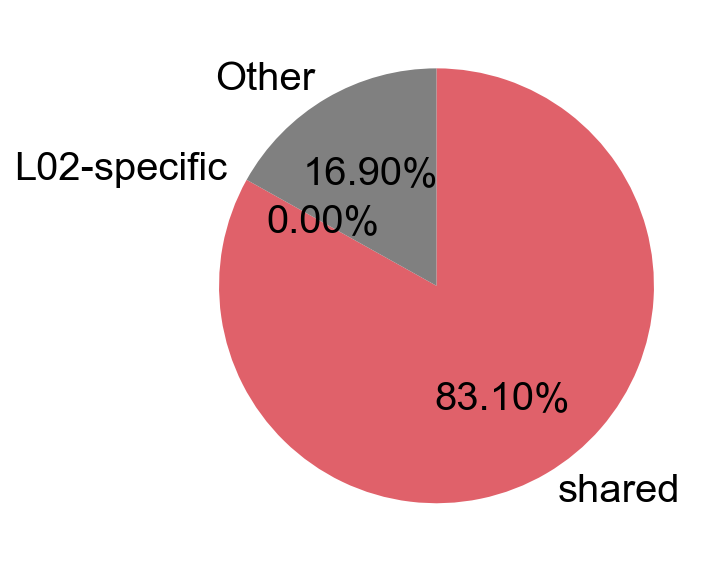

In [27]:
fig = plt.figure(figsize=(5,5))
ax21 = plt.subplot(111)
ax21.pie([nb_sc_bookmark_overlap_shared,nb_sc_bookmark_overlap_unique,nb_sc_bookmark-nb_sc_bookmark_overlap_shared-nb_sc_bookmark_overlap_unique], 
         labels=['shared','L02-specific','Other'], autopct='%1.2f%%', startangle=90, textprops={'fontsize': 20}, counterclock=False, 
         colors=['#e0616a','#d1976b','grey'])


In [28]:
peak_anno_df = pd.read_csv('./Data/top_filtered_peak.anno.txt', 
                           index_col=0, sep='\t')

In [29]:
bulk_anno_df = pd.read_csv('./Data/MitoChroAcce.annotateByHomer.txt', 
                           sep='\t', index_col=0)

In [32]:
bulk_peak_class_dict = {}
bulk_peak_class_dict['bulk_bookmarked'] = [x.strip().split('\t')[3] for x in open(bulk_bookmark_peak_file).readlines()]
bulk_peak_class_dict['bulk_shared'] = [x.strip().split('\t')[3] for x in open(bulk_shared_peak_file).readlines()]
bulk_peak_class_dict['bulk_unique'] = [x.strip().split('\t')[3] for x in open(bulk_unique_peak_file).readlines()]

In [33]:
peak_tss_dist_dict = {}
peak_tss_dist_dict['sc_bookmarked'] = peak_anno_df.loc[sc_bookmarked_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))
peak_tss_dist_dict['unbookmarked'] = peak_anno_df.loc[unbookmarked_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))

In [34]:
peak_tss_dist_dict['bulk_bookmarked'] = bulk_anno_df.loc[bulk_peak_class_dict['bulk_bookmarked'],'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))
peak_tss_dist_dict['bulk_shared'] = bulk_anno_df.loc[bulk_peak_class_dict['bulk_shared'],'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))
peak_tss_dist_dict['bulk_unique'] = bulk_anno_df.loc[bulk_peak_class_dict['bulk_unique'],'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))

In [35]:
tmp_dist_ls = []
tmp_prefix_ls = []

for prefix,dists in peak_tss_dist_dict.items():
    tmp_dist_ls.extend(dists)
    tmp_prefix_ls.extend([prefix]*len(dists))
result_dist_df = pd.DataFrame({'dist':tmp_dist_ls, 'prefix':tmp_prefix_ls})

In [36]:
bulk_bookmarked_not_sc_peaks = os.popen('bedtools intersect -a %s -b %s -v | sort -u | awk \'{print $4}\' ' % (bulk_bookmark_peak_file, sc_bookmarked_peak_file)).read().strip().split('\n')

In [37]:
peak_class_dict2 = {}

peak_class_dict2['sc_bookmarked'] = sc_bookmarked_peaks
peak_class_dict2['unbookmarked'] = unbookmarked_peaks
peak_class_dict2['bulk_bookmarked_unique'] = bulk_bookmarked_not_sc_peaks

In [38]:
peak_tss_dist_dict2 = {}
peak_tss_dist_dict2['sc_bookmarked'] = peak_anno_df.loc[sc_bookmarked_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))
peak_tss_dist_dict2['unbookmarked'] = peak_anno_df.loc[unbookmarked_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))
peak_tss_dist_dict2['bulk_bookmarked_unique'] = bulk_anno_df.loc[bulk_bookmarked_not_sc_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))

In [39]:
tmp_dist_ls = []
tmp_prefix_ls = []

for prefix,dists in peak_tss_dist_dict2.items():
    tmp_dist_ls.extend(dists)
    tmp_prefix_ls.extend([prefix]*len(dists))
result_dist_df = pd.DataFrame({'dist':tmp_dist_ls, 'prefix':tmp_prefix_ls})

In [40]:
sel_result_dist_df = result_dist_df[result_dist_df['prefix'].isin(['sc_bookmarked','bulk_bookmarked_unique'])]

# Fig S2J

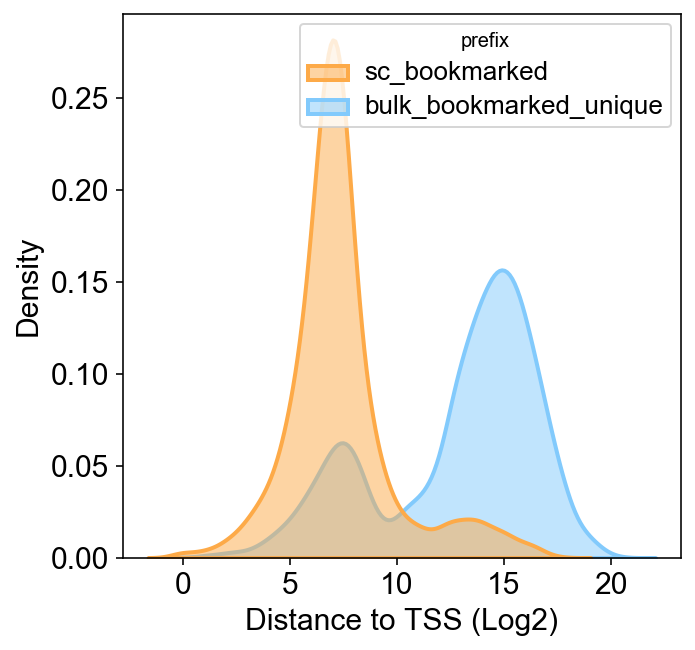

In [41]:
fig = plt.figure(figsize=(5,5))
ax21 = plt.subplot(111)
sns.kdeplot(data=sel_result_dist_df, x="dist", hue="prefix", common_norm=False, 
            ax=ax21, palette=['#fdaa48','#82cafc'], fill=True, alpha=.5, 
            linewidth=2)

for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
_ = ax21.set_xlabel('Distance to TSS (Log2)', fontsize=15)
_ = ax21.set_ylabel('Density', fontsize=15)
_ = plt.setp(ax21.get_legend().get_texts(), fontsize=13)

# Fig S2G

In [43]:
cut_top = 10

In [44]:
go_file = './Data/sc_bookmarked.MSigDB_Pathway.csv'
go_df = pd.read_csv(go_file, sep='\t')

In [45]:
go_df['-logPvalue'] = go_df['Binom_Raw_PValue'].map(lambda x: -math.log10(x))

In [46]:
go_df = go_df.iloc[:cut_top]
go_df.index = go_df['name']

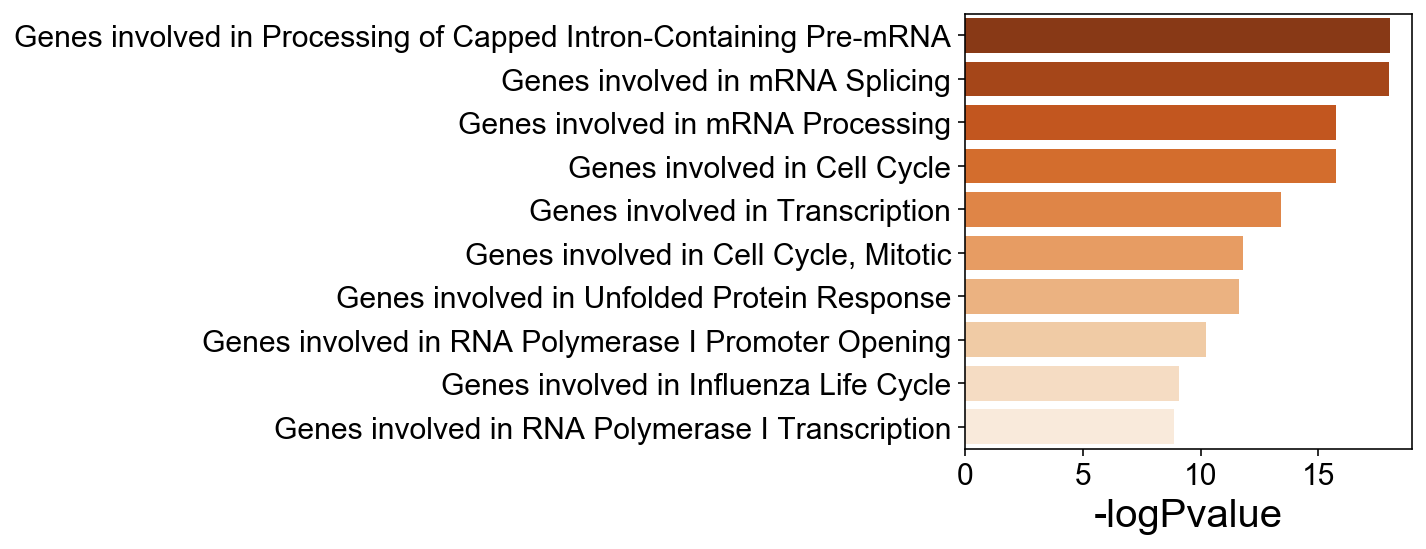

In [47]:
ax21 = plt.figure(figsize=(4,4)).add_subplot(111)
sns.barplot(x=go_df['-logPvalue'], y=go_df.index, 
            orient='h', palette="Oranges_r", ax=ax21)

for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
_ = ax21.set_xlabel('-logPvalue', fontsize=20)
_ = ax21.set_ylabel('')

# Fig 3E

In [48]:
proximal_peak_anno_df = peak_anno_df[peak_anno_df['Distance to TSS'].map(lambda x:abs(x))<=2500]

In [64]:
prefixs = ['sc_bookmarked','unbookmarked']

In [65]:
peak_class_dict = {}
peak_class_dict['sc_bookmarked'] = sc_bookmarked_peaks
peak_class_dict['unbookmarked'] = unbookmarked_peaks

In [66]:
def embedded_numbers(s):
    re_digits = re.compile(r'(\d+)')
    pieces = re_digits.split(s)
    pieces[1::2] = map(int, pieces[1::2])
    return pieces
def sort_strings_with_embedded_numbers(alist):
    return sorted(alist, key=embedded_numbers)

def prefixTrans(prefix):
    if prefix == '40min' or prefix == '80min':
        wave = 'fisrtWave'
    elif prefix == '105min' or prefix == '165min':
        wave = 'nextWave'
    elif prefix == '300min' or prefix == 'Async':
        wave = 'lastWave'
    elif prefix == 'liver':
        wave = 'liverSpe'
    return wave 

In [67]:
wave_ls = ['fisrtWave','nextWave','lastWave','liverSpe']
time_ls = ['40min','80min','105min','165min','300min','Async','liverSpe']

In [68]:
sciFiles = sort_strings_with_embedded_numbers(glob('./Data/transcripts_Supplemental_Tables//*_gene_S*.txt'))

In [69]:
sci_gene_dict = {}
for inFile in sciFiles:
    prefix = inFile.split('/')[-1].split('_')[0]
    sciGene_ls = list(set(pd.read_table(inFile,index_col=0).index))
    sci_gene_dict[prefix] = sciGene_ls

In [70]:
sci_gene_dict2 = {}
for inFile in sciFiles:
    prefix = inFile.split('/')[-1].split('_')[0]
    sciGene_ls = list(set(pd.read_table(inFile,index_col=0).index))
    
    if prefixTrans(prefix) not in sci_gene_dict2:
        sci_gene_dict2[prefixTrans(prefix)] = sciGene_ls
    else:
        sci_gene_dict2[prefixTrans(prefix)].extend(sciGene_ls)

In [71]:
peak_class_gene_dict = {}
for prefix in prefixs:
    prefix_peaks = peak_class_dict[prefix]
    prefix_genes = list(set(peak_anno_df.loc[prefix_peaks,'Gene Name']))
#     prefix_genes = list(set(proximal_peak_anno_df.loc[list(set(prefix_peaks).intersection(set(proximal_peak_anno_df.index))),'Gene Name']))
    prefix_genes.remove(np.nan)
    peak_class_gene_dict[prefix] = prefix_genes

In [73]:
bulk_peak_class_dict = {}
peak_file = './Data/lo2_bookmark.peaks.bed'
bulk_peak_class_dict['bulk_bookmarked'] = [x.strip().split('\t')[3] for x in open(peak_file).readlines()]
peak_file = './Data//hepG2_huh7_lo2_overlapbookmark.peaks.bed'
bulk_peak_class_dict['bulk_shared'] = [x.strip().split('\t')[3] for x in open(peak_file).readlines()]
peak_file = './Data/lo2_uniqbookmark.peaks.bed'
bulk_peak_class_dict['bulk_unique'] = [x.strip().split('\t')[3] for x in open(peak_file).readlines()]

In [74]:
bulk_peak_class_gene_dict = {}

for prefix,prefix_peaks in bulk_peak_class_dict.items():
    prefix_peaks = bulk_peak_class_dict[prefix]
    prefix_genes = list(set(bulk_anno_df.loc[prefix_peaks,'Gene Name']))
    prefix_genes.remove(np.nan)
    bulk_peak_class_gene_dict[prefix] = prefix_genes

In [75]:
wave_ls = []
peakclass_ls = []
ratio_ls = []

for prefix in prefixs:
    prefix_genes = peak_class_gene_dict[prefix]
    print(prefix, end='')
    
    for sci in ['fisrtWave', 'nextWave', 'lastWave']:
        sci_genes = sci_gene_dict2[sci]
        overlap_genes = list(set(prefix_genes).intersection(set(sci_genes)))
        print(' {0:.4f}'.format(len(overlap_genes)/len(prefix_genes)), end='')
        
        wave_ls.append(sci)
        peakclass_ls.append(prefix)
        ratio_ls.append(len(overlap_genes)/len(prefix_genes))
        
    print()
    
for prefix,prefix_genes in bulk_peak_class_gene_dict.items():
    print(prefix, end='')
    
    for sci in ['fisrtWave', 'nextWave', 'lastWave']:
        sci_genes = sci_gene_dict2[sci]
        overlap_genes = list(set(prefix_genes).intersection(set(sci_genes)))
        print(' {0:.4f}'.format(len(overlap_genes)/len(prefix_genes)), end='')
        
        wave_ls.append(sci)
        peakclass_ls.append(prefix)
        ratio_ls.append(len(overlap_genes)/len(prefix_genes))
        
    print()

result_ratio_df = pd.DataFrame({'wave':wave_ls, 'peakclass':peakclass_ls, 'ratio':ratio_ls})

sc_bookmarked 0.2515 0.0740 0.0687
unbookmarked 0.1899 0.1004 0.0786
bulk_bookmarked 0.1646 0.0909 0.0750
bulk_shared 0.2256 0.1141 0.0919
bulk_unique 0.1246 0.0930 0.0752


In [76]:
peak_tss_dist_dict2['sc_bookmarked'] = peak_anno_df.loc[sc_bookmarked_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))
peak_tss_dist_dict2['unbookmarked'] = peak_anno_df.loc[unbookmarked_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))
peak_tss_dist_dict2['bulk_bookmarked_unique'] = bulk_anno_df.loc[bulk_bookmarked_not_sc_peaks,'Distance to TSS'].map(lambda x:math.log2(abs(x)+1))

In [77]:
peak_gene_class_dict2 = {}
for prefix,prefix_peaks in peak_class_dict2.items():
    if re.match('bulk',prefix):
        prefix_genes = list(set(bulk_anno_df.loc[prefix_peaks,'Gene Name']))
        prefix_genes.remove(np.nan)
    else:
        prefix_genes = list(set(peak_anno_df.loc[prefix_peaks,'Gene Name']))
        prefix_genes.remove(np.nan)
    peak_gene_class_dict2[prefix] = prefix_genes

In [78]:
wave_ls = []
peakclass_ls = []
ratio_ls = []

for prefix,prefix_genes in peak_gene_class_dict2.items():
    print(prefix, end='')
    
    for sci in ['fisrtWave', 'nextWave', 'lastWave']:
        sci_genes = sci_gene_dict2[sci]
        overlap_genes = list(set(prefix_genes).intersection(set(sci_genes)))
        print(' {0:.4f}'.format(len(overlap_genes)/len(prefix_genes)), end='')
        
        wave_ls.append(sci)
        peakclass_ls.append(prefix)
        ratio_ls.append(len(overlap_genes)/len(prefix_genes))
        
    print()

result_ratio_df = pd.DataFrame({'wave':wave_ls, 'peakclass':peakclass_ls, 'ratio':ratio_ls})

sc_bookmarked 0.2515 0.0740 0.0687
unbookmarked 0.1899 0.1004 0.0786
bulk_bookmarked_unique 0.1591 0.0924 0.0756


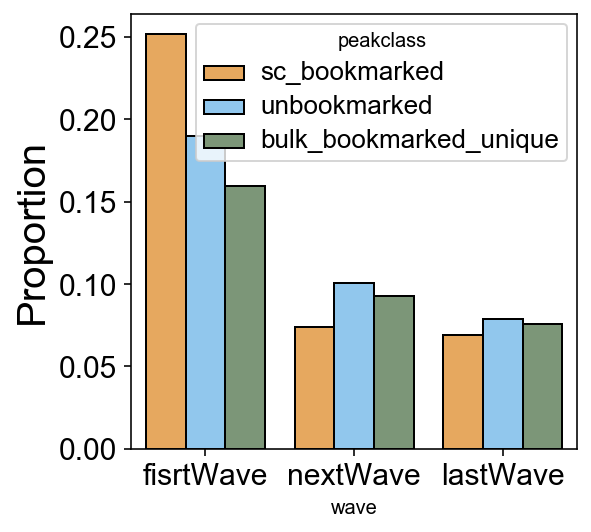

In [79]:
fig = plt.figure(figsize=(4,4))
ax21 = plt.subplot(111)

g = sns.barplot(x="wave", y="ratio", hue="peakclass", data=result_ratio_df, ax=ax21, 
                palette=['#fdaa48','#82cafc','#789b73'], edgecolor='black')
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
_ = ax21.set_ylabel('Proportion', fontsize=20)
_ = plt.setp(ax21.get_legend().get_texts(), fontsize=13)

# Fig 2F and 2G

In [80]:
combine_peak_class_gene_dict = peak_class_gene_dict.copy()
combine_peak_class_gene_dict.update(bulk_peak_class_gene_dict)

In [86]:
df_ls = []

for infile in glob('./Data/transcripts_Supplemental_Tables/*gene*zscore.csv'):
    sci_df = pd.read_csv(infile, index_col=0)
    sci_df['Group'] = sci_df.index
    sci_df = sci_df.groupby('Group').mean()
    df_ls.append(sci_df)

In [87]:
combine_sci_df = pd.concat(df_ls)
combine_sci_df['Cluster'] = combine_sci_df.index
combine_sci_df = combine_sci_df.groupby('Cluster').mean()

In [88]:
tmp_zscore_ls = []
tmp_prefix_ls = []

for prefix,prefix_genes in peak_gene_class_dict2.items():
    overlap_genes = list(set(prefix_genes).intersection(set(combine_sci_df.index)))
    tmp_zscore_ls.extend(combine_sci_df.loc[overlap_genes,'80min'])
    tmp_prefix_ls.extend([prefix]*len(overlap_genes))
    
result_zscore_df = pd.DataFrame({'zscore':tmp_zscore_ls, 'prefix':tmp_prefix_ls})

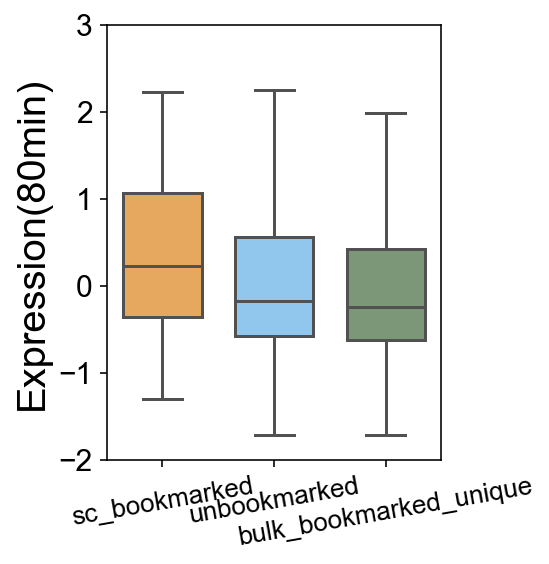

In [89]:
fig = plt.figure(figsize=(3,4))
ax21 = plt.subplot(111)

sns.boxplot(x='prefix', y='zscore', data=result_zscore_df, 
            ax=ax21, fliersize=0, width=0.7, palette=['#fdaa48','#82cafc','#789b73'])
_ = ax21.set_ylim([-2,3.0])

_ = plt.xticks(rotation=10)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
_ = ax21.set_xlabel('')
_ = ax21.set_ylabel('Expression(80min)', fontsize=20)

In [90]:
tmp_zscore_ls = []
tmp_prefix_ls = []

for prefix,prefix_genes in peak_gene_class_dict2.items():
    overlap_genes = list(set(prefix_genes).intersection(set(combine_sci_df.index)))
    tmp_zscore_ls.extend(combine_sci_df.loc[overlap_genes,'Async'])
    tmp_prefix_ls.extend([prefix]*len(overlap_genes))
    
result_zscore_df = pd.DataFrame({'zscore':tmp_zscore_ls, 'prefix':tmp_prefix_ls})

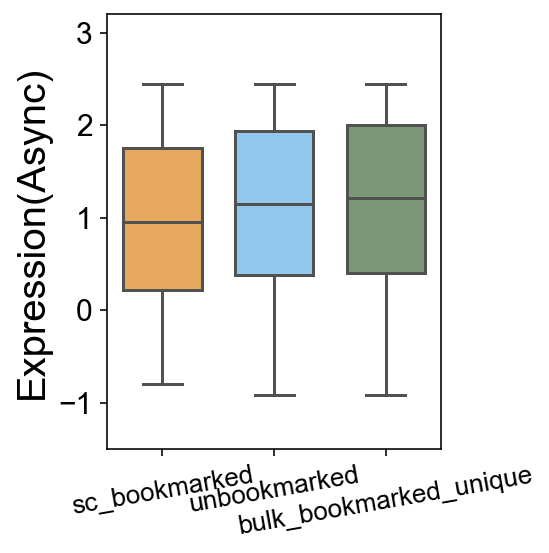

In [91]:
fig = plt.figure(figsize=(3,4))
ax21 = plt.subplot(111)

sns.boxplot(x='prefix', y='zscore', data=result_zscore_df, 
            ax=ax21, fliersize=0, width=0.7, palette=['#fdaa48','#82cafc','#789b73'])
_ = ax21.set_ylim([-1.5,3.2])

_ = plt.xticks(rotation=10)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
_ = ax21.set_xlabel('')
_ = ax21.set_ylabel('Expression(Async)', fontsize=20)

# Fig 2I and 2J

In [92]:
combine_peak_class_dict = peak_class_dict.copy()
combine_peak_class_dict.update(bulk_peak_class_dict)

In [93]:
nb_all_s = clus_binary_df.shape[1]
nb_sc_bookmarked = len(sc_bookmarked_peaks)

In [94]:
peak_sum = clus_binary_df.sum(axis=1)
peak_sum = peak_sum.sort_values()

In [95]:
other_peak_sum = peak_sum.loc[list(set(peak_sum.index)-set(sc_bookmarked_peaks))]
other_peak_sum = other_peak_sum.sort_values()

In [96]:
nb_part = int(other_peak_sum.shape[0] / nb_sc_bookmarked)

In [97]:
split_peaks_by_bookmark_ratio = []
ranks = []
count = 1
for i in range(nb_part):
    if i != nb_part-1:
        split_peaks = other_peak_sum.iloc[i*nb_sc_bookmarked:(i+1)*nb_sc_bookmarked].index.tolist()
        split_peaks_by_bookmark_ratio.append(split_peaks)
    else:
        split_peaks = other_peak_sum.iloc[i*nb_sc_bookmarked:].index.tolist()
        split_peaks_by_bookmark_ratio.append(split_peaks)
    ranks.append(other_peak_sum.loc[split_peaks].mean() / nb_all_s)
    count += 1
split_peaks_by_bookmark_ratio.append(sc_bookmarked_peaks)
# ranks.append(count)
ranks.append(1)

In [98]:
peak_rank_class_dict = {}
peak_rank_gene_dict = {}

for count,peaks in zip(ranks, split_peaks_by_bookmark_ratio):
    peak_rank_class_dict[count] = peaks
    prefix_genes = list(set(peak_anno_df.loc[peaks,'Gene Name']))
    prefix_genes.remove(np.nan)
    peak_rank_gene_dict[count] = prefix_genes

In [99]:
def embedded_numbers(s):
    re_digits = re.compile(r'(\d+)')
    pieces = re_digits.split(s)
    pieces[1::2] = map(int, pieces[1::2])
    return pieces
def sort_strings_with_embedded_numbers(alist):
    return sorted(alist, key=embedded_numbers)

def prefixTrans(prefix):
    if prefix == '40min' or prefix == '80min':
        wave = 'fisrtWave'
    elif prefix == '105min' or prefix == '165min':
        wave = 'nextWave'
    elif prefix == '300min' or prefix == 'Async':
        wave = 'lastWave'
    elif prefix == 'liver':
        wave = 'liverSpe'
    return wave 

In [104]:
wave_ls = []
peakclass_ls = []
ratio_ls = []

for prefix,prefix_genes in peak_rank_gene_dict.items():
#     print(prefix, end='')
    
    for sci in ['fisrtWave', 'nextWave', 'lastWave']:
        sci_genes = sci_gene_dict2[sci]
        overlap_genes = list(set(prefix_genes).intersection(set(sci_genes)))
#         print(' {0:.4f}'.format(len(overlap_genes)/len(prefix_genes)), end='')
        
        wave_ls.append(sci)
        peakclass_ls.append(prefix)
        ratio_ls.append(len(overlap_genes)/len(prefix_genes))
        
#     print()

result_ratio_df = pd.DataFrame({'wave':wave_ls, 'peakclass':peakclass_ls, 'ratio':ratio_ls})

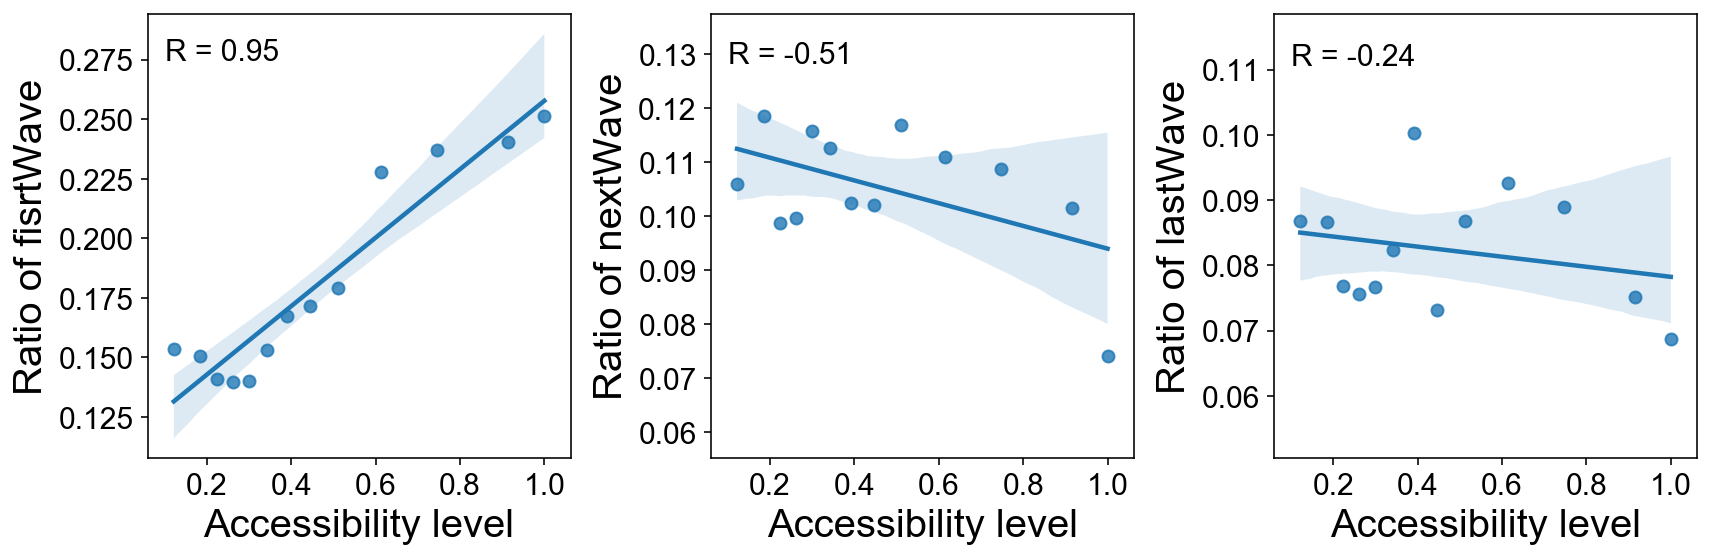

In [105]:
fig = plt.figure(figsize=(12,4))

count = 1
for sci in ['fisrtWave', 'nextWave', 'lastWave']:
    sel_result_ratio_df = result_ratio_df[result_ratio_df['wave']==sci]
    
    ax21 = plt.subplot(1,3,count)

#     ax21.scatter(count_ls, pc_ls, s=100, c='black')
    g = sns.regplot(x='peakclass', y='ratio', data=sel_result_ratio_df, ax=ax21)
    _ = ax21.set_xlabel('Accessibility level', fontsize=20)
    _ = ax21.set_ylabel('Ratio of '+sci, fontsize=20)
    ymin, ymax = ax21.get_ylim()
    _ = ax21.text(0.1, ymax - ymax/15, 'R = '+'{:.2f}'.format(linregress(sel_result_ratio_df['peakclass'], sel_result_ratio_df['ratio'])[2]), size=15)
    
    for tick in ax21.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    for tick in ax21.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    
    count += 1
plt.tight_layout()

In [106]:
tmp_zscore_ls = []
tmp_prefix_ls = []

for prefix,prefix_genes in peak_rank_gene_dict.items():
    overlap_genes = list(set(prefix_genes).intersection(set(combine_sci_df.index)))
    tmp_zscore_ls.extend(combine_sci_df.loc[overlap_genes,'80min'])
    tmp_prefix_ls.extend([prefix]*len(overlap_genes))
    
result_zscore_df = pd.DataFrame({'zscore':tmp_zscore_ls, 'prefix':tmp_prefix_ls})

In [107]:
tmp_zscore_ls = []
tmp_prefix_ls = []

for prefix,prefix_genes in peak_rank_gene_dict.items():
    overlap_genes = list(set(prefix_genes).intersection(set(combine_sci_df.index)))
    tmp_zscore_ls.append(combine_sci_df.loc[overlap_genes,'80min'].mean())
    tmp_prefix_ls.append(prefix)
    
result_zscore_df = pd.DataFrame({'zscore':tmp_zscore_ls, 'prefix':tmp_prefix_ls})

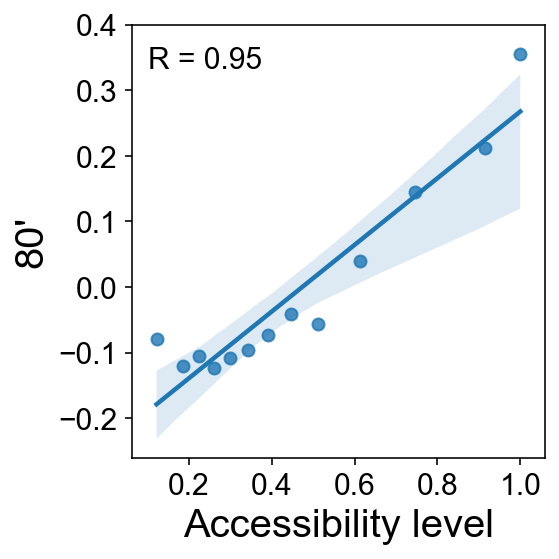

In [108]:
fig = plt.figure(figsize=(4,4))
    
ax21 = plt.subplot(111)
g = sns.regplot(x='prefix', y='zscore', data=result_zscore_df, ax=ax21)
_ = ax21.set_xlabel('Accessibility level', fontsize=20)
_ = ax21.set_ylabel('80\'', fontsize=20)
ymin, ymax = ax21.get_ylim()
_ = ax21.text(0.1, ymax - ymax/6, 'R = '+'{:.2f}'.format(linregress(result_zscore_df['prefix'], result_zscore_df['zscore'])[2]), size=15)

for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.tight_layout()

In [109]:
tmp_zscore_ls = []
tmp_prefix_ls = []

for prefix,prefix_genes in peak_rank_gene_dict.items():
    overlap_genes = list(set(prefix_genes).intersection(set(combine_sci_df.index)))
    tmp_zscore_ls.append(combine_sci_df.loc[overlap_genes,'Async'].mean())
    tmp_prefix_ls.append(prefix)
    
result_zscore_df = pd.DataFrame({'zscore':tmp_zscore_ls, 'prefix':tmp_prefix_ls})

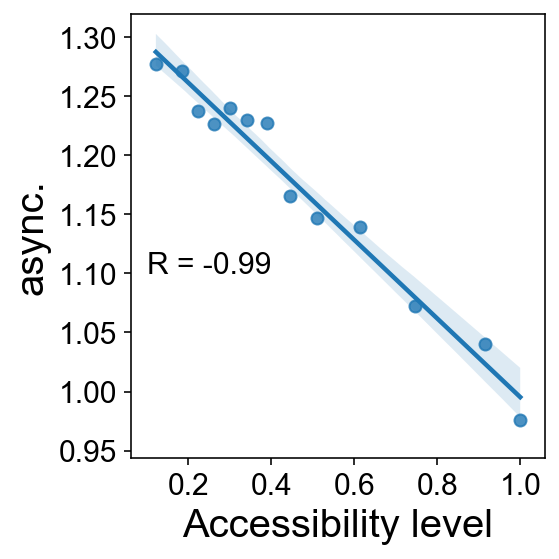

In [110]:
fig = plt.figure(figsize=(4,4))
    
ax21 = plt.subplot(111)
g = sns.regplot(x='prefix', y='zscore', data=result_zscore_df, ax=ax21)
_ = ax21.set_xlabel('Accessibility level', fontsize=20)
_ = ax21.set_ylabel('async.', fontsize=20)
ymin, ymax = ax21.get_ylim()
_ = ax21.text(0.1, ymax - ymax/6, 'R = '+'{:.2f}'.format(linregress(result_zscore_df['prefix'], result_zscore_df['zscore'])[2]), size=15)

for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.tight_layout()